In [2]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)

        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)
    
    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output , state = self.rnn(X)
        return output, state

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                      num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]  # outputs == (output, state), outputs[1] == state
    
    def forward(self, X, state):
        # 结合decoder输入和隐藏状态信息
        X = self.embedding(X).permute(1, 0, 2) # target, 目标语言序列输入
        context = state[-1].repeat(X.shape[0], 1, 1) # 当前最新的隐藏状态，重复n次用于和X拼接        
        X_and_context = torch.cat((X, context), 2)
        
        # RNN 层，生输出和隐藏状态
        output, state = self.rnn(X_and_context, state)
        # 通过一个线性层，将输出重新变为输入，即X和state的状态，用于下一次计算
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)

decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [33]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

---

（优雅，太优雅了）

**函数的作用**

这个函数的目的是：**将序列中超出有效长度的部分设置为指定值（通常是0）**

比如你有一个批次的句子，但每个句子长度不同，需要用padding填充到相同长度，然后用mask标记哪些位置是有效的。

1. 理解输入

In [8]:
# 假设输入：
X = torch.tensor([[1, 2, 3], 
                  [4, 5, 6]])        # 形状: (2, 3) - 2个序列，每个长度3
valid_len = torch.tensor([1, 2])     # 第1个序列有效长度1，第2个序列有效长度2

2. 获取最大长度

In [13]:
maxlen = X.size(1)
maxlen

3


3. 创建位置索引（核心技巧）

In [19]:
torch.arange(maxlen, dtype=torch.float32, device=X.device)

tensor([0., 1., 2.])

In [20]:
# 加上 [None, :] 变成行向量
torch.arange(maxlen, dtype=torch.float32, device=X.device)[None, :]

tensor([[0., 1., 2.]])

4. 处理有效长度（另一个核心技巧）

In [21]:
# 将 tensor([1, 2]) 变成列向量
valid_len[:, None]

tensor([[1],
        [2]])

5. 广播比较（最精彩的部分！）

In [ ]:

# 展开来看：
# tensor([[0., 1., 2.]])  <  tensor([[1],
#                                   [2]])
# 
# 广播后比较：
# [[0., 1., 2.]]  <  [[1, 1, 1],      # 第1行：每个位置都与1比较
#                     [2, 2, 2]]      # 第2行：每个位置都与2比较
mask = torch.arange(maxlen)[None, :] < valid_len[:, None]
mask

tensor([[ True, False, False],
        [ True,  True, False]])

6. 应用掩码

In [28]:
X[~mask] = 0  # ~mask 表示取反，即False的位置设为value
X


tensor([[[1., 1., 1., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [0., 0., 0., 0.]]])

---

In [30]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [35]:
class MaskSoftmaxCEloss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none' # 有mask，所以不能做reduction
        unweighted_loss = super(MaskSoftmaxCEloss, self).forward(
            pred.permute(0, 2, 1), label) 
        # 换顺序是因为 nn.CrossEntropyLoss 要求的输入类型是 (mini-batch, 类别, 维度)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [36]:
loss = MaskSoftmaxCEloss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

# label是3个长为4的序列，mask最后一位为0，所以最后一个序列完全没有计算loss

tensor([2.3026, 1.1513, 0.0000])

In [44]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [41]:
def train_seq2seq(net, data_iter, lr, num_eopchs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                # 只初始化权重，不初始化偏置（置零）
                # 偏置在GRU中包含意义：
                # 重置门（R）：初始时不倾向与重置或保留
                # 更新门（Z）：初始时不倾向于更新或保持
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskSoftmaxCEloss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_eopchs])
    for epoch in range(num_eopchs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)    
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # 强制教学，在真实目标上训练，忽略错误的预测值
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()  # 需要计算有效tokens的数量，不然无法计算平均损失             
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.019, 21583.2 tokens/sec on cuda:0


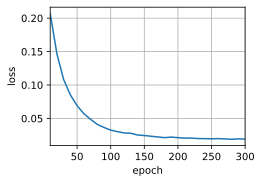

In [46]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [48]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """
    seq2seq模型预测函数 - 将源语言句子翻译成目标语言
    
    参数:
    - net: 训练好的seq2seq模型（包含encoder和decoder）
    - src_sentence: 源语言句子（字符串），例如 "hello world"
    - src_vocab: 源语言词汇表，用于将词转换为ID
    - tgt_vocab: 目标语言词汇表，用于将ID转换为词
    - num_steps: 最大生成长度，防止无限生成
    - device: 计算设备（cpu或gpu）
    - save_attention_weights: 是否保存注意力权重（当前版本未使用）
    
    返回:
    - 翻译后的目标语言句子（字符串）
    - 注意力权重序列（当前为空列表）
    """
    
    # === 第一阶段：模型准备 ===
    # 设置模型为评估模式，关闭dropout和batch normalization的训练行为
    net.eval()
    
    # === 第二阶段：源句子预处理 ===
    # 步骤：字符串 → 词列表 → ID列表 → 添加结束符
    # 例如: "hello world" → ["hello", "world"] → [vocab_id1, vocab_id2] → [vocab_id1, vocab_id2, eos_id]
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    # src_vocab[word_list] 会自动将词列表转换为对应的ID列表
    # 添加<eos>是为了明确标记源序列的结束
    
    # 记录原始源序列的真实长度（用于encoder处理时的mask）
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    # 形状: (1,) - 只有一个句子，所以长度为1的tensor
    
    # 对源序列进行填充或截断，统一长度为num_steps
    # 如果序列太短，用<pad>填充；如果太长，进行截断
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 现在src_tokens的长度固定为num_steps
    
    # === 第三阶段：准备encoder输入 ===
    # 将Python列表转换为PyTorch tensor，并添加batch维度
    # 从形状 [seq_len] 变成 [1, seq_len]，因为batch_size=1
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    # enc_X形状: (1, num_steps) - 1个句子，长度为num_steps
    
    # === 第四阶段：编码器处理 ===
    # 编码器将源语言序列编码成语义表示（隐藏状态）
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    # enc_outputs是一个元组: (encoder_output, encoder_state)
    # - encoder_output: 每个时间步的输出 (seq_len, 1, hidden_size)
    # - encoder_state: 最终隐藏状态 (num_layers, 1, hidden_size)
    
    # === 第五阶段：初始化解码器 ===
    # 用编码器的最终状态来初始化解码器的隐藏状态
    # 这样解码器就能"知道"源句子的语义信息
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # dec_state就是encoder的最终隐藏状态，包含了源句子的语义信息
    
    # 准备解码器的第一个输入：<bos>（开始符）
    # 解码器需要知道"现在开始生成目标语言"
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    # dec_X形状: (1, 1) - batch_size=1, seq_len=1，内容是<bos>的token_id
    
    # === 第六阶段：准备输出容器 ===
    output_seq = []              # 存储生成的词ID序列
    attention_weight_seq = []    # 存储注意力权重（当前版本未使用）
    
    # === 第七阶段：自回归解码（核心生成过程）===
    # "自回归"：用已生成的词来预测下一个词
    for _ in range(num_steps):  # 最多生成num_steps个词，防止无限循环
        
        # 7.1 解码器前向传播
        # 输入：当前词(dec_X) + 隐藏状态(dec_state)
        # 输出：下一个词的概率分布 + 更新的隐藏状态
        Y, dec_state = net.decoder(dec_X, dec_state)
        # Y: 词汇表上的概率分布 (1, 1, vocab_size)
        # dec_state: 更新后的隐藏状态，包含到目前为止的所有信息
        
        # 7.2 贪心选择：选择概率最大的词
        # 在实际应用中，也可以用beam search等更复杂的搜索策略
        dec_X = Y.argmax(dim=2)  # 在词汇表维度(dim=2)上找最大值的索引
        # Y: (1, 1, vocab_size) → dec_X: (1, 1)，内容是预测词的token_id
        
        # 7.3 提取预测词的ID（转换为Python整数）
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 操作分解：
        # squeeze(dim=0): (1, 1) → (1,) - 去掉batch维度
        # type(torch.int32): 转换数据类型确保兼容性
        # item(): 从单元素tensor中提取Python整数
        
        # 7.4 保存注意力权重（如果需要可视化的话）
        # 注意：当前的基础seq2seq没有attention机制，所以这部分不会执行
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        
        # 7.5 检查是否到达序列结束
        # 如果生成了<eos>（结束符），说明翻译完成
        if pred == tgt_vocab['<eos>']:
            break  # 提前结束生成循环
        
        # 7.6 将预测词添加到输出序列
        output_seq.append(pred)
        # output_seq现在包含了从开始到当前生成的所有词的ID
        
        # 重要：dec_X会在下一轮循环中作为decoder的输入
        # 这就是"自回归"的核心：用刚生成的词来生成下一个词
    
    # === 第八阶段：后处理和返回结果 ===
    # 将词ID序列转换回可读的文本
    # tgt_vocab.to_tokens(): 将ID列表 [1, 5, 9] 转换为词列表 ["I", "love", "you"]
    # ' '.join(): 将词列表用空格连接成句子 "I love you"
    translated_sentence = ' '.join(tgt_vocab.to_tokens(output_seq))
    
    # 返回翻译结果和注意力权重（用于可视化分析）
    return translated_sentence, attention_weight_seq

In [68]:
def bleu(pred_seq, label_seq, k):
    """
    BLEU (Bilingual Evaluation Understudy) 评分函数
    用于评估机器翻译质量，分数越高表示翻译质量越好
    
    参数:
    - pred_seq: 模型预测的翻译结果（字符串），例如 "I love you"
    - label_seq: 标准参考翻译（字符串），例如 "I adore you"  
    - k: 计算到k-gram的匹配度，通常k=4
    
    返回:
    - BLEU分数（0到1之间的浮点数）
    """
    
    # === 第一步：文本预处理 ===
    # 将句子按空格分割成词列表
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    # 例如: "I love you" → ["I", "love", "you"]
    # 例如: "I adore you" → ["I", "adore", "you"]
    
    # 计算预测序列和参考序列的长度
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    # 例如: len_pred = 3, len_label = 3
    
    # === 第二步：长度惩罚项（Brevity Penalty）===
    # BLEU会惩罚过短的翻译，避免模型生成很短但高精度的句子来"作弊"
    score = math.exp(min(0, 1 - len_label / len_pred))
    # 分析这个公式：
    # - 如果 len_pred >= len_label：1 - len_label/len_pred >= 0，min()取0，exp(0)=1，无惩罚
    # - 如果 len_pred < len_label：1 - len_label/len_pred < 0，exp()>1，但min()取0，bleu减小

    
    # === 第三步：n-gram精确度计算 ===
    # 对于每个n-gram级别（1-gram, 2-gram, ..., k-gram）
    for n in range(1, k + 1):  # n = 1, 2, 3, ..., k
        
        # 初始化计数器
        num_matches = 0  # 匹配的n-gram数量
        label_subs = collections.defaultdict(int)  # 参考序列中n-gram的计数字典
        
        # === 3.1：统计参考序列中所有n-gram ===
        # 遍历参考序列，提取所有可能的n-gram
        for i in range(len_label - n + 1):
            # 提取从位置i开始的n个连续词
            ngram = ' '.join(label_tokens[i: i + n])
            # 例如当n=2，i=0: label_tokens[0:2] → "I adore"
            # 例如当n=2，i=1: label_tokens[1:3] → "adore you"
            
            # 在字典中记录这个n-gram出现的次数
            label_subs[ngram] += 1
        # 此时label_subs包含了参考序列中所有n-gram及其出现次数
        
        # === 3.2：检查预测序列中的n-gram匹配情况 ===
        # 遍历预测序列，检查每个n-gram是否在参考序列中出现
        for i in range(len_pred - n + 1):
            # 提取从位置i开始的n个连续词
            ngram = ' '.join(pred_tokens[i: i + n])
            # 例如当n=2，i=0: pred_tokens[0:2] → "I love"
            
            # 检查这个n-gram是否在参考序列中存在且还有剩余计数
            if label_subs[ngram] > 0:
                num_matches += 1        # 找到一个匹配，计数+1
                label_subs[ngram] -= 1  # 消耗掉参考序列中的一个计数
                # 这样做是为了避免重复匹配：
                # 如果预测序列中有多个相同的n-gram，但参考序列中只有1个，
                # 那么只能匹配1次，不能重复计分
        
        # === 3.3：计算当前n-gram级别的精确度 ===
        # 精确度 = 匹配的n-gram数量 / 预测序列中总的n-gram数量
        precision_n = num_matches / (len_pred - n + 1)
        # 例如：2-gram精确度 = 匹配的2-gram数 / 预测序列中2-gram总数
        
        # === 3.4：将当前精确度加权融入总分 ===
        # BLEU使用几何平均，每个n-gram级别的权重是 0.5^n
        weight = math.pow(0.5, n)  # n越大，权重越小
        # n=1: weight=0.5, n=2: weight=0.25, n=3: weight=0.125, n=4: weight=0.0625
        
        # 使用对数形式计算几何平均：log(a*b) = log(a) + log(b)
        # 这里用乘法实现：score *= precision_n^weight
        score *= math.pow(precision_n, weight)
    
    # === 第四步：返回最终BLEU分数 ===
    return score
    # BLEU分数范围：0-1，越接近1表示翻译质量越好

In [64]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):3f}')

go . => va !, bleu 1.000000
i lost . => j'ai <unk> perdu ., bleu 0.658037
he's calm . => il est riche ., bleu 0.658037
i'm home . => je suis détendu !, bleu 0.418438
